In [184]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [185]:
from Processing.get_data import download_with_cache
from Processing.STAT import STATPOP, STATENT
from Area import Area


In [39]:
import pandas as pd
import matplotlib.pyplot as plt

In [33]:
download_with_cache("https://www.bfs.admin.ch/bfsstatic/dam/assets/32686751/master", "STATPOT2023.csv", zip=True, zip_file_name="STATPOP2023.csv", method="GET")

('data\\1_downloaded\\STATPOT2023.csv', datetime.date(2025, 1, 2))

In [38]:
df = pd.read_csv('data\\1_downloaded\\STATPOT2023.csv', sep=";")
df

,ERHJAHR,PUBJAHR,RELI,E_KOORD,N_KOORD,BBTOT,BB11,BB12,BB13,BB14,...,BB55,BB56,HPTOT,HP01,HP02,HP03,HP04,HP05,HP06,HPI
0,2023,2024,48621114,2486200,1111400,5,4,3,3,0,...,0,0,3,3,3,0,0,0,0,1.0
1,2023,2024,48621115,2486200,1111500,3,3,0,0,0,...,0,0,3,3,0,0,0,0,0,1.0
2,2023,2024,48631114,2486300,1111400,4,4,0,0,0,...,0,0,3,0,0,0,3,0,0,1.0
3,2023,2024,48631117,2486300,1111700,3,3,0,0,0,...,0,0,3,0,0,3,0,0,0,1.0
4,2023,2024,48641116,2486400,1111600,30,22,8,7,0,...,0,0,11,3,3,5,3,0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347403,2023,2024,83101690,2831000,1169000,3,3,0,0,0,...,0,0,3,0,0,3,0,0,0,1.0
347404,2023,2024,83101692,2831000,1169200,3,3,0,0,0,...,0,0,3,3,3,0,0,0,0,1.0
347405,2023,2024,83111692,2831100,1169200,3,3,0,0,0,...,0,0,3,3,0,0,0,0,0,1.0
347406,2023,2024,83111693,2831100,1169300,9,9,0,0,0,...,0,0,4,3,3,3,0,0,0,1.0


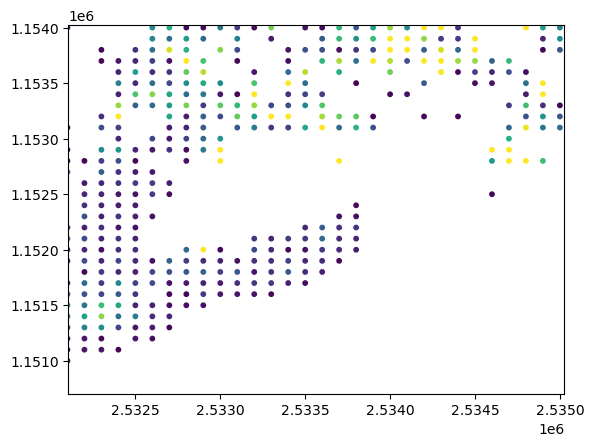

In [57]:
plt.scatter(data=df, x="E_KOORD", y="N_KOORD", c="BBTOT", s=10,  vmin=0, vmax=200)
plt.xlim(2532106,2535027)
plt.ylim(1150700,1154028)
plt.show()

In [47]:
df.BBTOT.max()

np.int64(4046)

In [65]:
next(iter(ASSETS_PER_YEAR.keys()))

2023

In [69]:
epfl = Area("EPFL", 2532106, 2535027, 1150700, 1154028)
epfl.plot_interactive()

In [383]:
population = STATPOP(epfl)
population.df

,POSITION_X,POSITION_Y,POPULATION
18317,2532100,1151000,6
18318,2532100,1151100,6
18319,2532100,1151200,9
18320,2532100,1151300,30
18321,2532100,1151400,73
...,...,...,...
20105,2535000,1153200,54
20106,2535000,1153300,3
20107,2535000,1153800,52
20108,2535000,1153900,98


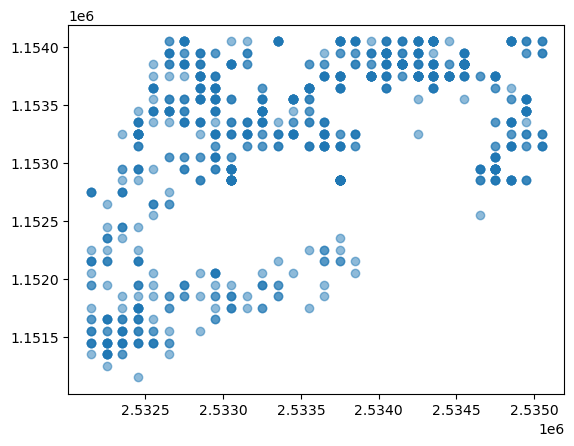

array([[2534250, 1154050],
       [2532250, 1151350],
       [2533850, 1153850],
       ...,
       [2532650, 1152650],
       [2534050, 1153950],
       [2532450, 1152150]], shape=(1000, 2))

In [373]:
pop_demand = population.generate_n(1000, seed = 10)
plt.scatter(pop_demand[:, 0], pop_demand[:, 1], alpha=0.5)
plt.show()
pop_demand

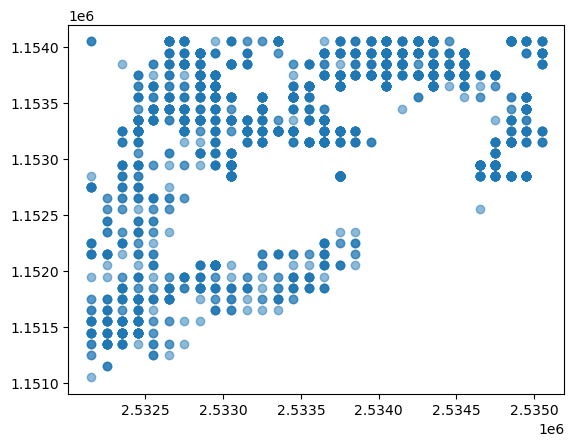

In [377]:
pop_demand2 = population.generate_per_proportion(0.1, seed = 100)
plt.scatter(pop_demand2[:, 0], pop_demand2[:, 1], alpha=0.5)

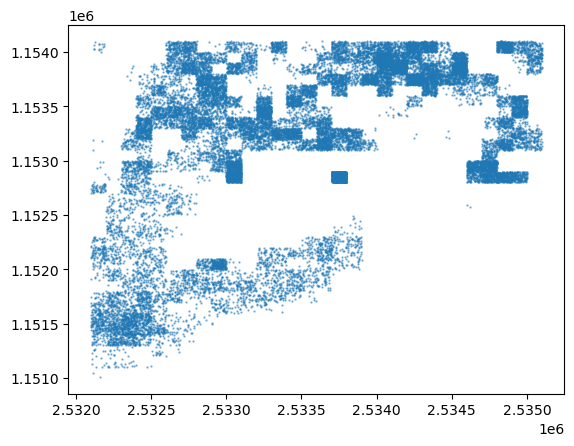

array([[2533676.5, 1153383.5],
       [2532912.5, 1151859.5],
       [2533208.5, 1153428.5],
       ...,
       [2532663.5, 1153916.5],
       [2534840.5, 1152866.5],
       [2534282.5, 1154083.5]], shape=(27262, 2))

In [379]:
pop_demand_jitter = population.generate_per_proportion(proportion=1, precision_in_meter=1, seed = 100)
plt.scatter(pop_demand_jitter[:, 0], pop_demand_jitter[:, 1], alpha=0.5, s=0.5)
plt.show()
pop_demand_jitter

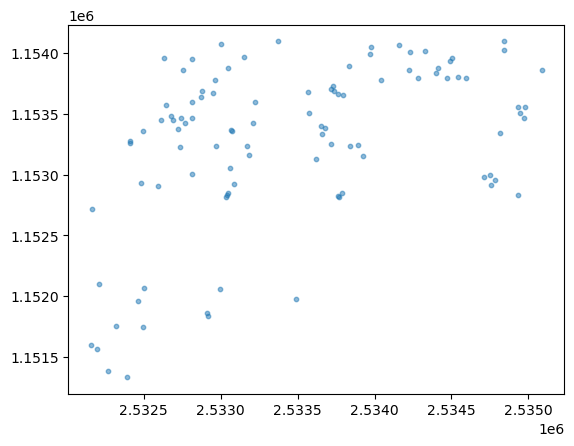

In [381]:
pop_demand_jitter = population.generate_n(100, precision_in_meter=1, seed = 100)
plt.scatter(pop_demand_jitter[:, 0], pop_demand_jitter[:, 1], alpha=0.5, s=10)
plt.show()

In [382]:
entreprises = STATENT(epfl)
entreprises.df

,POSITION_X,POSITION_Y,SHOPS,SHOPS_EMP,SHOPS_ETP,SHOPS_0,SHOPS_10,SHOPS_50,SHOPS_250
12331,2532100,1151300,0,0,0.0,0,0,0,0
12332,2532100,1151400,0,0,0.0,0,0,0,0
12333,2532100,1151500,0,0,0.0,0,0,0,0
12334,2532100,1151700,0,0,0.0,0,0,0,0
12335,2532100,1151900,0,0,0.0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
13730,2535000,1153600,0,0,0.0,0,0,0,0
13731,2535000,1153700,0,0,0.0,0,0,0,0
13732,2535000,1153800,0,0,0.0,0,0,0,0
13733,2535000,1153900,4,4,4.0,4,0,0,0


In [390]:
entreprises.df.SHOPS_ETP.sum()

np.float64(509.52775569999994)

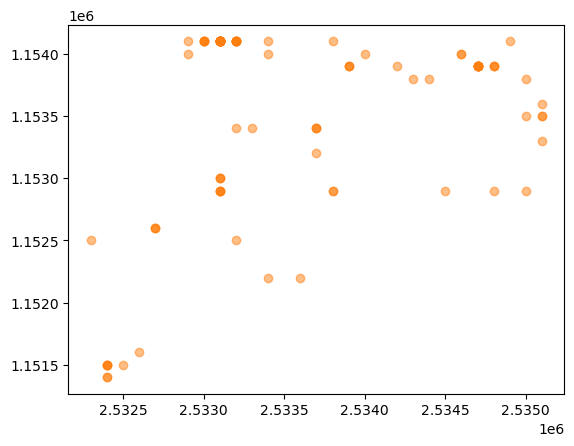

array([[2534700, 1153900],
       [2532400, 1151400],
       [2533900, 1153900],
       [2534600, 1154000],
       [2533200, 1154100],
       [2533100, 1152900],
       [2533000, 1154100],
       [2534700, 1153900],
       [2533000, 1154100],
       [2532700, 1152600],
       [2534300, 1153800],
       [2535100, 1153300],
       [2532300, 1152500],
       [2533200, 1154100],
       [2534700, 1153900],
       [2533800, 1152900],
       [2534500, 1152900],
       [2533100, 1153000],
       [2535000, 1153500],
       [2534400, 1153800],
       [2533400, 1152200],
       [2532900, 1154100],
       [2533100, 1154100],
       [2534200, 1153900],
       [2533200, 1152500],
       [2533100, 1154100],
       [2533800, 1154100],
       [2533200, 1154100],
       [2534000, 1154000],
       [2533700, 1153400],
       [2534700, 1153900],
       [2533200, 1154100],
       [2535000, 1152900],
       [2533100, 1154100],
       [2532700, 1152600],
       [2533100, 1154100],
       [2532900, 1154000],
 

In [413]:
ent_sources = entreprises.generate_n(100, weights="SHOPS_ETP", seed = 10)
plt.scatter(ent_sources[:, 0], ent_sources[:, 1], alpha=0.5, c="C1")
plt.show()
ent_sources

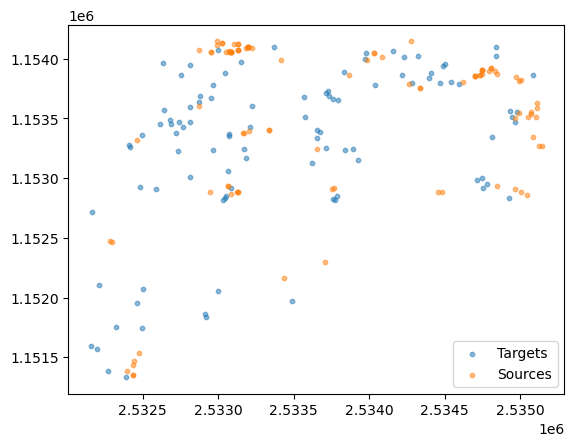

In [414]:
pop_demand_jitter = population.generate_n(100, 1, seed = 100)
plt.scatter(pop_demand_jitter[:, 0], pop_demand_jitter[:, 1], alpha=0.5, s=10, label="Targets")
ent_sources_jitter = entreprises.generate_n(100, 10, weights="SHOPS_ETP", seed = 200)
plt.scatter(ent_sources_jitter[:, 0], ent_sources_jitter[:, 1], alpha=0.5, s=10, c="C1", label="Sources")
plt.legend()
plt.show()

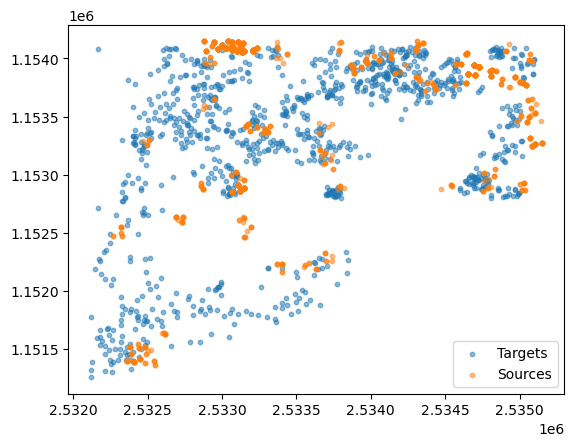

In [415]:
pop_demand_jitter = population.generate_n(1000, 1, seed = 100)
plt.scatter(pop_demand_jitter[:, 0], pop_demand_jitter[:, 1], alpha=0.5, s=10, label="Targets")
ent_sources_jitter = entreprises.generate_n(1000, 1, weights="SHOPS_ETP", seed = 200)
plt.scatter(ent_sources_jitter[:, 0], ent_sources_jitter[:, 1], alpha=0.5, s=10, c="C1", label="Sources")
plt.legend()
plt.show()

In [101]:
import numpy as np

In [141]:
np.random.Generator.integers(5, size=(10,2)) * 20

TypeError: integers() takes at least 1 positional argument (0 given)

In [145]:
np.random.default_rng?

Signature:      np.random.default_rng(seed=None)
Call signature: np.random.default_rng(*args, **kwargs)
Type:           cython_function_or_method
String form:    <cyfunction default_rng at 0x000002173823DA40>
Docstring:     
default_rng(seed=None)
Construct a new Generator with the default BitGenerator (PCG64).

    Parameters
    ----------
    seed : {None, int, array_like[ints], SeedSequence, BitGenerator, Generator, RandomState}, optional
        A seed to initialize the `BitGenerator`. If None, then fresh,
        unpredictable entropy will be pulled from the OS. If an ``int`` or
        ``array_like[ints]`` is passed, then all values must be non-negative and will be
        passed to `SeedSequence` to derive the initial `BitGenerator` state. One may also
        pass in a `SeedSequence` instance.
        Additionally, when passed a `BitGenerator`, it will be wrapped by
        `Generator`. If passed a `Generator`, it will be returned unaltered.
        When passed a legacy `Rando